In [6]:
import os
import pandas as pd

# Load captions file
captions_file = "captions.txt"
captions_data = pd.read_csv(captions_file, header=None, names=["image", "caption"])

# Create a dictionary mapping image names to captions
captions_dict = {}
for i, row in captions_data.iterrows():
    image = row["image"]
    caption = row["caption"]

    # Add caption to the image's list of captions
    if image not in captions_dict:
        captions_dict[image] = []
    captions_dict[image].append(caption)

# Example: Print first few entries
for image, captions in list(captions_dict.items())[:5]:
    print(image, captions)


image ['caption']
1000268201_693b08cb0e.jpg ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']
1001773457_577c3a7d70.jpg ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']
1002674143_1b742ab4b8.jpg ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .', 'There is a girl wit

In [7]:
import string

# Preprocess captions
def preprocess_caption(caption):
    caption = caption.lower().translate(str.maketrans('', '', string.punctuation))
    return f"<start> {caption} <end>"

for image, captions in captions_dict.items():
    captions_dict[image] = [preprocess_caption(c) for c in captions]

# Example after preprocessing
print(list(captions_dict.values())[:5])


[['<start> caption <end>'], ['<start> a child in a pink dress is climbing up a set of stairs in an entry way  <end>', '<start> a girl going into a wooden building  <end>', '<start> a little girl climbing into a wooden playhouse  <end>', '<start> a little girl climbing the stairs to her playhouse  <end>', '<start> a little girl in a pink dress going into a wooden cabin  <end>'], ['<start> a black dog and a spotted dog are fighting <end>', '<start> a black dog and a tricolored dog playing with each other on the road  <end>', '<start> a black dog and a white dog with brown spots are staring at each other in the street  <end>', '<start> two dogs of different breeds looking at each other on the road  <end>', '<start> two dogs on pavement moving toward each other  <end>'], ['<start> a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl  <end>', '<start> a little girl is sitting in front of a large painted rainbow  <end>', '<start> a small girl in the gras

In [8]:
from sklearn.model_selection import train_test_split

# Extract image filenames
image_filenames = list(captions_dict.keys())

# Split into train, val, and test
train_images, val_images = train_test_split(image_filenames, test_size=0.2, random_state=42)
val_images, test_images = train_test_split(val_images, test_size=0.5, random_state=42)

print(f"Training: {len(train_images)}, Validation: {len(val_images)}, Test: {len(test_images)}")


Training: 6473, Validation: 809, Test: 810


In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

# Initialize ResNet50
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Function to extract features from an image
def extract_features(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = resnet_model.predict(img_array, verbose=0)
    return np.squeeze(features)  # Remove the extra dimension

# Extract and save features for all images
images_folder = "Images"
features_dict = {}

for image_file in os.listdir(images_folder):
    image_base = os.path.basename(image_file)  # Normalize key
    if image_base in captions_dict:  # Only process images with captions
        image_path = os.path.join(images_folder, image_file)
        features_dict[image_base] = extract_features(image_path)

# Verify feature shapes
print(f"Extracted features for {len(features_dict)} images")
print("Sample feature shape:", next(iter(features_dict.values())).shape)


Extracted features for 8091 images
Sample feature shape: (2048,)


In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Flatten all captions into a list
all_captions = [caption for captions in captions_dict.values() for caption in captions]

# Tokenize captions
tokenizer = Tokenizer(num_words=5000, oov_token="<unk>")
tokenizer.fit_on_texts(all_captions)

# Save tokenizer for later use
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

# Convert captions to sequences
max_length = max(len(c.split()) for c in all_captions)
print(f"Maximum caption length: {max_length}")


Vocabulary size: 8831
Maximum caption length: 38


In [20]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os

def create_training_data(features_dict, captions_dict, tokenizer, max_length):
    X1, X2, y = [], [], []

    # Normalize feature keys to match caption keys
    features_dict_normalized = {os.path.basename(k): v for k, v in features_dict.items()}

    for image, captions in captions_dict.items():
        if image not in features_dict_normalized:
            print(f"Skipping {image} - not found in features_dict")
            continue  # Skip missing images

        for caption in captions:
            sequence = tokenizer.texts_to_sequences([caption])[0]
            for i in range(1, len(sequence)):
                # Input sequence and next word
                in_seq, out_word = sequence[:i], sequence[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]  # Ensure padding to max_length

                # One-hot encode the output word
                out_word_encoded = np.zeros(vocab_size)
                out_word_encoded[out_word] = 1.0

                X1.append(features_dict_normalized[image])
                X2.append(in_seq)
                y.append(out_word_encoded)

    return np.array(X1), np.array(X2), np.array(y)

# Check and adjust max_length if needed (ensure it's consistent with your padding)
max_length = 34  # Maximum sequence length (ensure it's the correct value)
small_captions_dict = dict(list(captions_dict.items())[:500])
X1_train, X2_train, y_train = create_training_data(features_dict, small_captions_dict, tokenizer, max_length)

# Verify shapes
print("X1_train shape:", X1_train.shape)  # Should be (num_samples, 2048)
print("X2_train shape:", X2_train.shape)  # Should be (num_samples, max_length)
print("y_train shape:", y_train.shape)    # Should be (num_samples, vocab_size)


Skipping image - not found in features_dict
X1_train shape: (30108, 2048)
X2_train shape: (30108, 34)
y_train shape: (30108, 8831)


In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Concatenate

# Define model inputs
image_input = Input(shape=(2048,))
image_dense = Dense(256, activation='relu')(image_input)

text_input = Input(shape=(max_length,))
text_embedding = Embedding(vocab_size, 256, mask_zero=True)(text_input)
text_lstm = LSTM(256)(text_embedding)

# Combine image and text features
decoder = Concatenate()([image_dense, text_lstm])
output = Dense(vocab_size, activation='softmax')(decoder)

model = Model(inputs=[image_input, text_input], outputs=output)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 34, 256)   │  2,260,736 │ input_layer_11[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 34)        │          0 │ input_layer_11[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │    524,544 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 256)       │    525,312 │ embedding_4[0][0… │
│                     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 512)       │          0 │ dense_8[0][0],    │
│ (Concatenate)       │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 8831)      │  4,530,303 │ concatenate_4[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,840,895 (29.91 MB)

 Trainable params: 7,840,895 (29.91 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model

# Define input dimensions
feature_dim = 2048  # ResNet feature size
max_length = 34  # Maximum caption length
vocab_size = 8831  # Vocabulary size

# Define model inputs
image_input = Input(shape=(feature_dim,), name="image_input")  # Image features
text_input = Input(shape=(max_length,), name="text_input")  # Captions

# Process image features
image_features = Dense(256, activation="relu")(image_input)

# Process text input
embedding = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=True)(text_input)
lstm_output = LSTM(256)(embedding)

# Combine features
decoder = Concatenate()([image_features, lstm_output])
output = Dense(vocab_size, activation="softmax")(decoder)

# Define and compile the model
model = Model(inputs=[image_input, text_input], outputs=output)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
model.fit([X1_train, X2_train], y_train, epochs=20, batch_size=64, verbose=1)


Epoch 1/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 49s 99ms/step - accuracy: 0.1980 - loss: 5.2787
Epoch 2/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 46s 98ms/step - accuracy: 0.3430 - loss: 3.2888
Epoch 3/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 46s 97ms/step - accuracy: 0.4088 - loss: 2.5727
Epoch 4/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 46s 98ms/step - accuracy: 0.4608 - loss: 2.1299
Epoch 5/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 47s 100ms/step - accuracy: 0.5066 - loss: 1.8420
Epoch 6/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 45s 96ms/step - accuracy: 0.5539 - loss: 1.6067
Epoch 7/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 45s 96ms/step - accuracy: 0.5966 - loss: 1.4297
Epoch 8/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 46s 97ms/step - accuracy: 0.6398 - loss: 1.2713
Epoch 9/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 51s 109ms/step - accuracy: 0.6684 - loss: 1.1439
Epoch 10/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 52s 111ms/step - accuracy: 0.7053 - loss: 1.0179
Epoch 11/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 47s 100ms/step - accuracy: 0.7328 - loss: 0.9219
Epoch 12/20
471/471 ━━━━━━

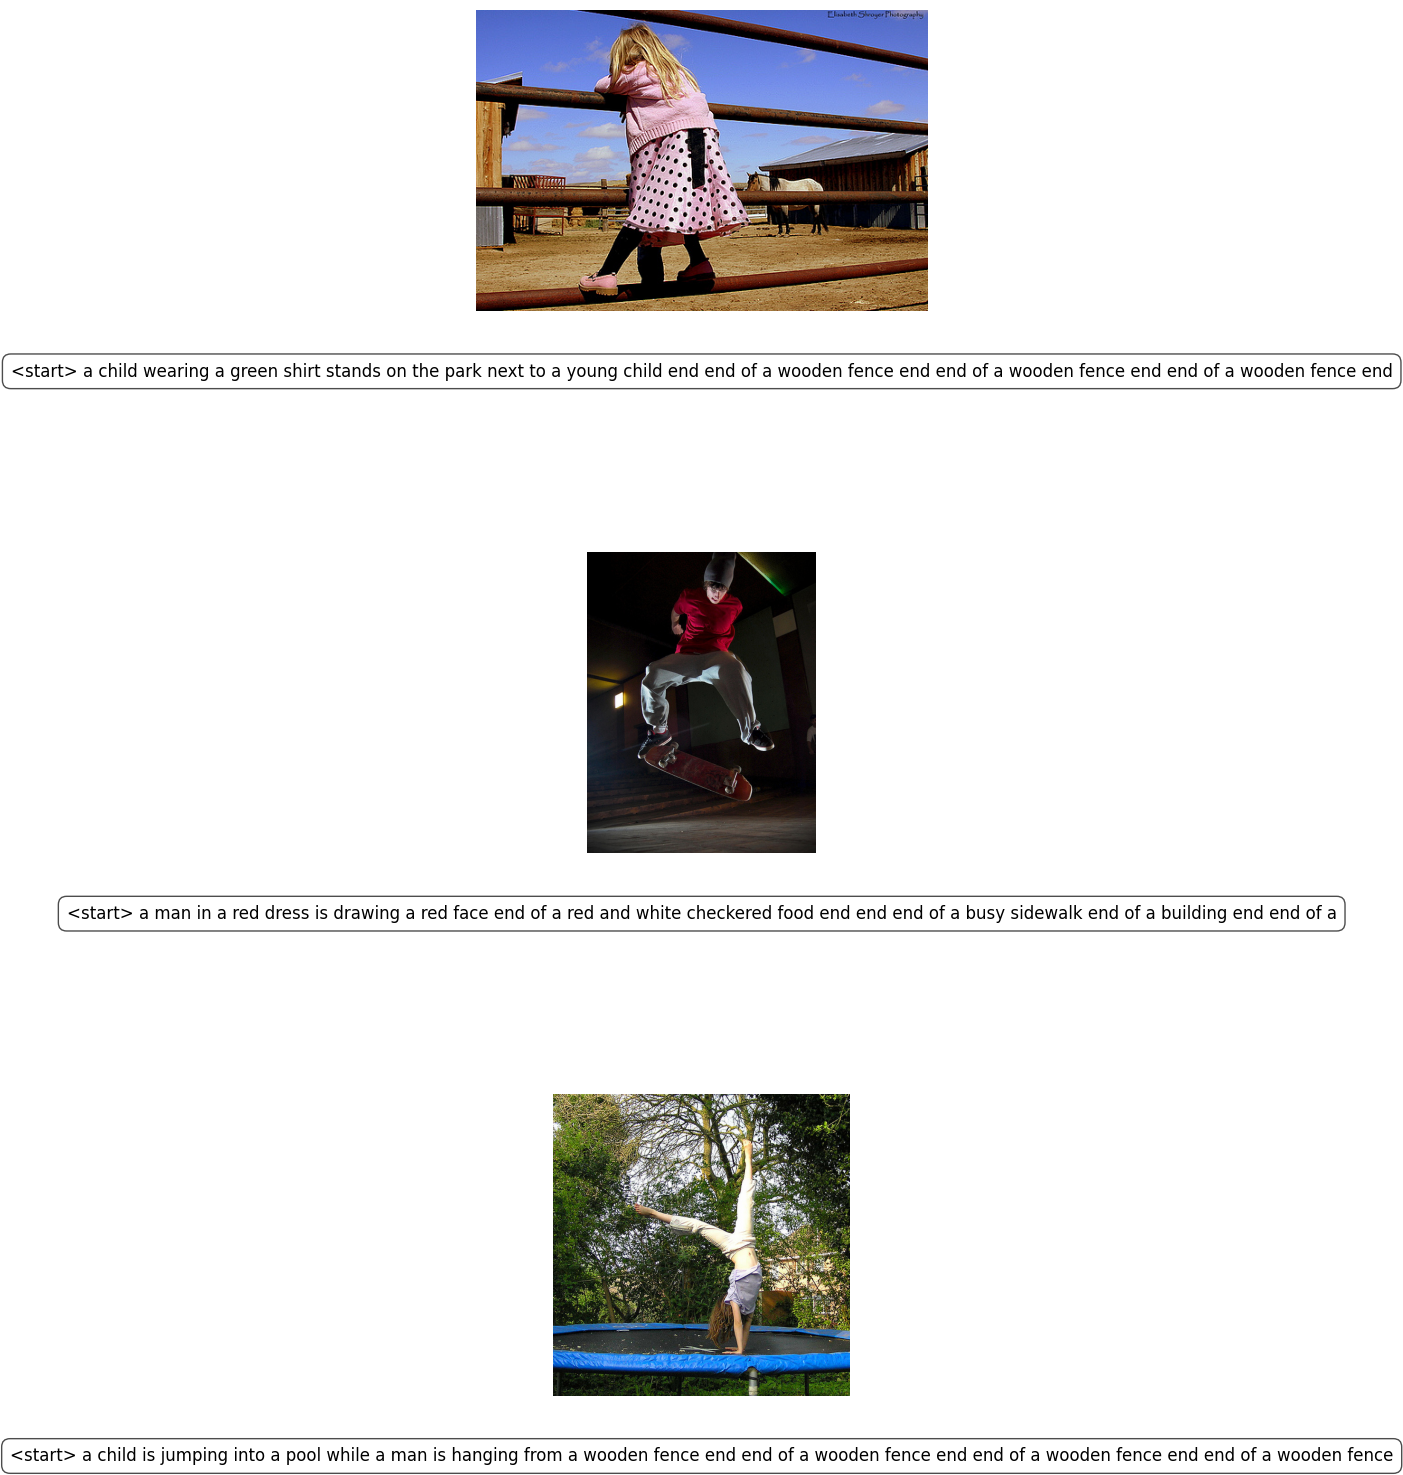

In [43]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from PIL import Image

# Function to generate a caption for an image
def generate_caption(image_feature, tokenizer, model, max_length):
    caption = '<start>'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        # Reshape image_feature to match the model input
        image_feature_reshaped = np.reshape(image_feature, (1, image_feature.shape[0]))
        # Predict the next word
        y_pred = np.argmax(model.predict([image_feature_reshaped, sequence], verbose=0))
        word = tokenizer.index_word[y_pred]
        if word == '<end>':
            break
        caption += ' ' + word
    return caption

# Pick 3 random images from the test set
random_images = random.sample(test_images, 3)

# Set up the plot (3 rows and 1 column)
fig, axes = plt.subplots(3, 1, figsize=(10, 18))  # Increase the height to fit 3 images vertically

# Loop through the 3 random images
for i, random_image in enumerate(random_images):
    # Extract features for the selected image
    image_path = os.path.join(images_folder, random_image)
    image_feature = features_dict[os.path.basename(random_image)]

    # Generate caption for the image
    generated_caption = generate_caption(image_feature, tokenizer, model, max_length)

    # Load the image and convert it to RGB (in case it's in another format)
    img = Image.open(image_path).convert('RGB')

    # Display the image in the subplot
    axes[i].imshow(img)
    axes[i].axis('off')  # Turn off axis

    # Add a text box with the caption below the image
    axes[i].text(0.5, -0.2, generated_caption, ha='center', va='center', fontsize=12,
                 transform=axes[i].transAxes, bbox=dict(facecolor='white', alpha=0.7,
                                                      boxstyle="round,pad=0.5"))

# Adjust layout for better spacing between images
plt.subplots_adjust(hspace=0.8)  # Increased vertical spacing between subplots
plt.show()
